In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

# The Sampling demo

This demo is an example of sampling. In summary, it consists of iteratively retrieving random samples (batches) from the patients tables, in order to approximate the percentage of female and male patients.
Following the instructions shown in the [README.md file](../README.md), the `app.py` (which runs the server) should have been successfully executed.
We then configure these variables (run the following cell):

In [2]:
domain_name="localhost"
port=3000
auth_token = json.dumps(
            {
                "email":"1000@gmail.com",
                 "password":"qwert2000"
            })

Then, we define a function that will be used to send requests to the server

In [3]:
def query(table_name="patient",uri="",payload="",headers={},action="GET"):
    url = f"http://{domain_name}:{port}/tables/{table_name}{uri}"

    response = requests.request(action, url, headers=headers, data=payload)

    return(json.loads(response.text))

## The Sampling loop (online aggregation)

This is an example of online aggregation. The purpose of this example is to assist in determining the number of samples needed to approximate the percentages of female and male patients, without the need of retrieving the whole patients table. This can help in case it is needed to be performed on low end devices with small RAMs. It consists of iteratively retrieving random samples (batches) from the patients tables, and aggregating the results online. 

The code below implements this idea. Comments have been added for more clarity.

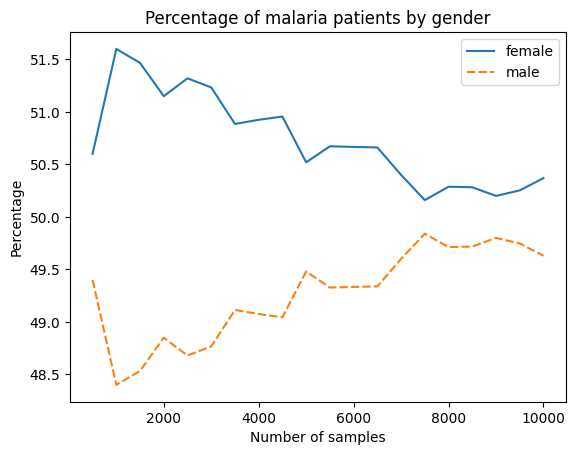

Fetched entries: 10000 out of 10000
Done Querying!


In [4]:
previous_indexes = []  # List to store the previous indexes
sample_patients_dict_df = pd.DataFrame()  # Empty DataFrame to store the sampled patients
gender_df = None  # Initialize the gender DataFrame as None
len_previous_indexes=[]  # List to store the length of previous indexes
while(True):
    # Retrieve a batch of random samples from the patients table
    sample_patients_dict = query(table_name="patient",
          uri="/sampling",
          payload=json.dumps({
                  "batch_size": 500,
                  "previous_indexes": previous_indexes
                }),
          headers={
              'Authorization': auth_token,
              'Content-Type': 'application/json'
            },
          action="GET")
    if 'error' in sample_patients_dict.keys():
        print(sample_patients_dict)
        break
    # Convert the sampled patients dictionary to a DataFrame
    sample_patients_dict_df = pd.DataFrame.from_dict(sample_patients_dict["data"],orient='index')
    if gender_df is None:
        # If gender_df is None, initialize it with the first batch of sampled patients
        gender_df = sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
        gender_df_history = 100*gender_df/gender_df.sum(axis=1)[0]
    else:
        # Add the current batch of sampled patients to gender_df
        gender_df = gender_df + sample_patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "population"}).T
        gender_df_history = pd.concat([gender_df_history,100*gender_df/gender_df.sum(axis=1)[0]],axis=0,ignore_index=True)
    # Update the previous_indexes list with the current batch of sampled patients' IDs
    previous_indexes = previous_indexes+sample_patients_dict_df["id"].tolist()
    # Append the length of previous_indexes to len_previous_indexes
    len_previous_indexes.append(len(previous_indexes))
    # Set the index of gender_df_history to len_previous_indexes
    gender_df_history["samples"] = len_previous_indexes
    gender_df_history=gender_df_history.set_index("samples")
    display.clear_output(wait=True)
    sns.lineplot(gender_df_history)
    plt.legend()
    plt.title("Percentage of malaria patients by gender")
    plt.xlabel("Number of samples")
    plt.ylabel("Percentage")
    plt.show()

    print("Fetched entries:",len_previous_indexes[-1],"out of",
          sample_patients_dict["original_table_length"],end="\r")
    if len(previous_indexes)==sample_patients_dict["original_table_length"]:
        print("")
        print("Done Querying!")
        break

The graph displayed above shows how the percentage by gender updated as more samples were being randomly retrieved. It can be seen that the aggregation results gradually converged. The same pattern can be seen after re-running the above program, even though the samples are being retrieved randomly. 

## The online aggregation results vs the ground truth

Referring the table below (which is showing how the online aggregation updated with respect to the total number of retrieved samples), the aggregation converges to the table's last row.

In [5]:
gender_df_history

gender,female,male
samples,,
500,50.600000,49.400000
1000,51.600000,48.400000
1500,51.466667,48.533333
2000,51.150000,48.850000
2500,51.320000,48.680000
3000,51.233333,48.766667
3500,50.885714,49.114286
4000,50.925000,49.075000
4500,50.955556,49.044444


The final row can be compared to the ground truth, by first retrieving the whole table, and then performing a straight forward aggregation.

In [6]:
patients_dict = query(table_name="patient",
          uri="",
          payload="",
          headers={
              'Authorization': auth_token,
              'Content-Type': 'application/json'
            },
          action="GET")
patients_dict_df = pd.DataFrame.from_dict(patients_dict,orient='index')
gender_df_ground_truth = patients_dict_df.groupby(by=["gender"]).count()[["id"]].rename(columns={"id": "percentages"}).T
gender_df_history_gt = 100*gender_df_ground_truth/gender_df_ground_truth.sum(axis=1)[0]
gender_df_history_gt["samples"] = [len(patients_dict_df)]
gender_df_history_gt=gender_df_history_gt.set_index("samples")
gender_df_history_gt

gender,female,male
samples,,
10000,50.37,49.63


It can be seen that the online aggregation converged to the right results. Whowever, one might be satisfied with retrieving few samples instead of the whole table. Therefore, it is important to experiment with online aggregation to find a satisfactory number of samples. Approaches of computing confidence metrics such as the [Central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) and [Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) can be used for better evaluation.